# 영화 리뷰 감정 분석

In [1]:
# 데이터 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings(action='ignore')

# Naver movie corpus 불러오기
train_file = tf.keras.utils.get_file('ratings_train.txt',
  origin='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
train = pd.read_csv(train_file, sep='\t')

14639104/14628807 [==============================] - 0s 0us/step


# EDA

In [2]:
train.shape

(150000, 3)

In [3]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# 레이블별 개수
cnt = train['label'].value_counts()
cnt


0    75173
1    74827
Name: label, dtype: int64

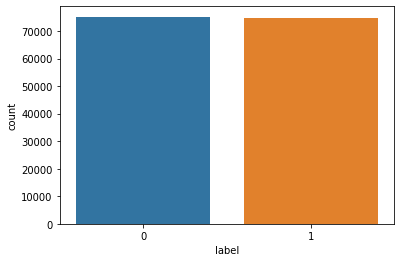

In [5]:
sns.countplot(x='label', data=train)

In [6]:
# 결측치
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [7]:
# 결측치가 특정 label값만 있는지 확인
train[train['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


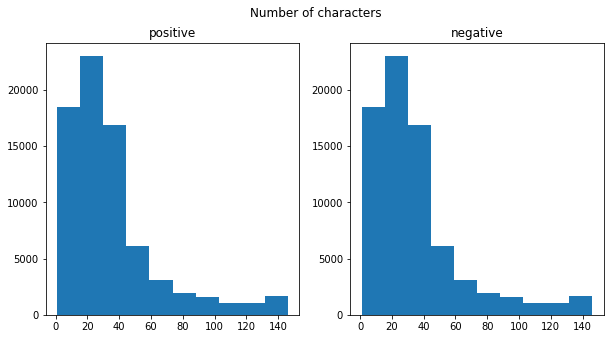

In [8]:
# 레이블 별 텍스트 길이
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
data_len = train[train['label'] == 1]['document'].str.len()
ax1.hist(data_len)
ax1.set_title('positive')

deata_len = train[train['label'] == 0]['document'].str.len()
ax2.hist(data_len)
ax2.set_title('negative')
fig.suptitle('Number of characters')
plt.show()

In [9]:
#Mecab 형태소 분석기 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [10]:
!cd Mecab-ko-for-Google-Colab/; bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 43.0 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-08-24 04:03:00--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c2:513, 2406:da00:ff00::22c3:9b0a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=9kG6gmF6YhQkA77uhp%2BN29rREJ0%3D

In [11]:
import konlpy
from konlpy.tag import Kkma, Komoran, Okt, Mecab
kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

In [12]:
# 형태소별 샘플
text = '영실아안녕오늘날씨어때?'
def sample_ko_pos(text):
  print(f'==={text}===')
  print('kkma: ', kkma.pos(text))
  print('komoran: ', komoran.pos(text))
  print('okt: ', okt.pos(text))
  print('mecab: ', mecab.pos(text))
  print('\n')

In [13]:
sample_ko_pos(text)

===영실아안녕오늘날씨어때?===
kkma:  [('영', 'MAG'), ('싣', 'VV'), ('아', 'ECD'), ('안녕', 'NNG'), ('오늘날', 'NNG'), ('씨', 'VV'), ('어', 'ECD'), ('때', 'NNG'), ('?', 'SF')]
komoran:  [('영', 'NNP'), ('실', 'NNP'), ('아', 'NNP'), ('안녕', 'NNP'), ('오늘날', 'NNP'), ('씨', 'NNB'), ('어떻', 'VA'), ('어', 'EF'), ('?', 'SF')]
okt:  [('영', 'Modifier'), ('실아', 'Noun'), ('안녕', 'Noun'), ('오늘날', 'Noun'), ('씨', 'Suffix'), ('어때', 'Adjective'), ('?', 'Punctuation')]
mecab:  [('영실', 'NNG'), ('아', 'IC'), ('안녕', 'IC'), ('오늘', 'MAG'), ('날씨', 'NNG'), ('어때', 'VA+EF'), ('?', 'SF')]




In [14]:
text2 = '영실아안뇽오늘날씨어때?'
sample_ko_pos(text2)

===영실아안뇽오늘날씨어때?===
kkma:  [('영', 'MAG'), ('싣', 'VV'), ('아', 'ECD'), ('안', 'MAG'), ('뇽', 'UN'), ('오늘날', 'NNG'), ('씨', 'NNB'), ('어', 'VV'), ('어', 'ECS'), ('때', 'NNG'), ('?', 'SF')]
komoran:  [('영실아안뇽오늘날씨어때?', 'NA')]
okt:  [('영', 'Modifier'), ('실아', 'Noun'), ('안뇽', 'Noun'), ('오늘날', 'Noun'), ('씨', 'Suffix'), ('어때', 'Adjective'), ('?', 'Punctuation')]
mecab:  [('영실', 'NNG'), ('아안', 'NNG'), ('뇽오늘날씨어때', 'UNKNOWN'), ('?', 'SF')]




In [15]:
text3 = '정말 재미있고 매력적인 영화에요 추천합니다.'
sample_ko_pos(text3)

===정말 재미있고 매력적인 영화에요 추천합니다.===
kkma:  [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'ECE'), ('매력적', 'NNG'), ('이', 'VCP'), ('ㄴ', 'ETD'), ('영화', 'NNG'), ('에', 'JKM'), ('요', 'JX'), ('추천', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EFN'), ('.', 'SF')]
komoran:  [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'EC'), ('매력', 'NNG'), ('적', 'XSN'), ('이', 'VCP'), ('ㄴ', 'ETM'), ('영화', 'NNG'), ('에', 'JKB'), ('요', 'JX'), ('추천', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EF'), ('.', 'SF')]
okt:  [('정말', 'Noun'), ('재미있고', 'Adjective'), ('매력', 'Noun'), ('적', 'Suffix'), ('인', 'Josa'), ('영화', 'Noun'), ('에요', 'Josa'), ('추천', 'Noun'), ('합니다', 'Verb'), ('.', 'Punctuation')]
mecab:  [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'EC'), ('매력', 'NNG'), ('적', 'XSN'), ('인', 'VCP+ETM'), ('영화', 'NNG'), ('에', 'JKB'), ('요', 'MM'), ('추천', 'NNG'), ('합니다', 'XSV+EF'), ('.', 'SF')]




In [16]:
# 데이터 전처리, 영어, 한글만 남김.
train['document'] = train['document'].str.replace('[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ]', "")
train['document'].head()

0                                        아더빙진짜짜증나네요목소리
1                              흠포스터보고초딩영화줄오버연기조차가볍지않구나
2                                    너무재밓었다그래서보는것을추천한다
3                                 교도소이야기구먼솔직히재미는없다평점조정
4    사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...
Name: document, dtype: object

In [17]:
# 결측치 제거
train = train.dropna()
train.shape

(149995, 3)

In [18]:
# 스톱워드(불용어)와 형태소 분석
def word_tokenization(text):
  stop_words = ['는', '을', '를', '이', '가', '의', '던', '고', '하', '다', 
                '은', '에', '들', '지', '게', '도']
  return [word for word in mecab.morphs(text) if word not in stop_words]

In [19]:
data = train['document'].apply((lambda x: word_tokenization(x)))
data.head()

0                      [아, 더, 빙, 진짜, 짜증, 나, 네, 요목, 소리]
1       [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 않, 구나]
2                              [너무, 재, 밓었다그래서보는것을추천한다]
3                   [교도소, 이야기, 구먼, 솔직히, 재미, 없, 평점, 조정]
4    [사이몬페그, 익살, 스런, 연기, 돋보였, 영화, 스파이더맨, 에서, 늙, 어, ...
Name: document, dtype: object

In [20]:
# train, validation 분할
training_size = 120000
train_sentences = data[:training_size]
valid_sentences = data[training_size:]
# label 분할
train_labels = train['label'][:training_size]
valid_labels = train['label'][training_size:]

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# vocab_size설정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
print('총 단어 갯수: ', len(tokenizer.word_index))

# 5회 이상만 vocab_size에 포함
def get_vocab_size(threshold):
  cnt = 0
  for x in tokenizer.word_counts.values():
    if x >= threshold:
      cnt = cnt + 1
  return cnt
vocab_size = get_vocab_size(5)
print('vocab_size: ', vocab_size)

총 단어 갯수:  59849
vocab_size:  15675


In [22]:
oov_tok = '<OOV>' # 사전에 없는 단어
vocab_size = 15000

tokenizer = Tokenizer(oov_token=oov_tok, num_words=vocab_size)
tokenizer.fit_on_texts(data)
print(tokenizer.word_index)
print('단어 사전 개수: ', len(tokenizer.word_counts))

{'<OOV>': 1, '영화': 2, '한': 3, '보': 4, '있': 5, '없': 6, '좋': 7, '나': 8, '었': 9, '는데': 10, '만': 11, '너무': 12, '봤': 13, '적': 14, '로': 15, '안': 16, '정말': 17, '으로': 18, '것': 19, '음': 20, '지만': 21, '네요': 22, '어': 23, '아': 24, '같': 25, '재밌': 26, '진짜': 27, '에서': 28, '했': 29, '기': 30, '네': 31, '않': 32, '았': 33, '거': 34, '수': 35, '되': 36, '면': 37, '과': 38, '인': 39, 'ㅋㅋ': 40, '말': 41, '연기': 42, '점': 43, '최고': 44, '잘': 45, '평점': 46, '주': 47, '이런': 48, '내': 49, '와': 50, '어요': 51, '할': 52, '겠': 53, '왜': 54, '스토리': 55, '습니다': 56, '해': 57, 'ㅋㅋㅋ': 58, '아니': 59, '듯': 60, '드라마': 61, '그': 62, '생각': 63, '사람': 64, '싶': 65, '더': 66, '감동': 67, '때': 68, '까지': 69, '배우': 70, '함': 71, '본': 72, '보다': 73, '좀': 74, '만들': 75, '뭐': 76, '내용': 77, '감독': 78, '알': 79, '볼': 80, '재미있': 81, '라': 82, '그냥': 83, '시간': 84, '지루': 85, '재미없': 86, '중': 87, '재미': 88, '잼': 89, '였': 90, '쓰레기': 91, '사랑': 92, '못': 93, '냐': 94, '라고': 95, '서': 96, '년': 97, '면서': 98, '다시': 99, '니': 100, '나오': 101, '작품': 102, '번': 103, '하나': 104, '이거': 105, '

In [23]:
print(train_sentences[:2])
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
print(train_sequences[:2])

0                   [아, 더, 빙, 진짜, 짜증, 나, 네, 요목, 소리]
1    [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 않, 구나]
Name: document, dtype: object
[[24, 66, 886, 27, 219, 8, 31, 1, 466], [1018, 487, 321, 633, 2, 108, 1557, 42, 773, 1009, 32, 370]]


In [24]:
# 문장의 최대 길이
max_length = max(len(x) for x in train_sequences)
print('문장 최대 길이:', max_length)

문장 최대 길이: 75


In [25]:
# 문장 길이를 동일하게 맞춘다
trunc_type = 'post'
padding_type = 'post'
train_padded = pad_sequences(train_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
valid_padded = pad_sequences(valid_sequences, truncating=trunc_type, padding=padding_type, maxlen=max_length)
train_labels = np.asarray(train_labels)
valid_labels = np.asarray(valid_labels)
print('샘플:', train_padded[:1])

샘플: [[ 24  66 886  27 219   8  31   1 466   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]]


In [26]:
# 모델 구축
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, SimpleRNN

def create_model():
  model = Sequential([
                      Embedding(vocab_size, 32),
                      Bidirectional(LSTM(32, return_sequences=True)),
                      Dense(32, activation='relu'),
                      Dense(1, activation='sigmoid')
                      ])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          480000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
dense (Dense)                (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
Total params: 498,753
Trainable params: 498,753
Non-trainable params: 0
_________________________________________________________________


In [27]:
# callback : 가장 좋은 loss의 가중치 저장
checkpoint_path = 'best_performed_model.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True,
                                                save_best_only=True,
                                                monitor='val_loss',
                                                verbose=1)

In [28]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [29]:
# 학습
history = model.fit(train_padded, train_labels,
                    validation_data=(valid_padded, valid_labels),
                    callbacks=[early_stop, checkpoint],
                    batch_size=32,
                    epochs=10, verbose=2)

Epoch 1/10
3750/3750 - 163s - loss: 0.4063 - accuracy: 0.8130 - val_loss: 0.3638 - val_accuracy: 0.8331

Epoch 00001: val_loss improved from inf to 0.36379, saving model to best_performed_model.ckpt
Epoch 2/10
3750/3750 - 140s - loss: 0.3201 - accuracy: 0.8596 - val_loss: 0.3533 - val_accuracy: 0.8494

Epoch 00002: val_loss improved from 0.36379 to 0.35328, saving model to best_performed_model.ckpt
Epoch 3/10
3750/3750 - 141s - loss: 0.2796 - accuracy: 0.8790 - val_loss: 0.3481 - val_accuracy: 0.8462

Epoch 00003: val_loss improved from 0.35328 to 0.34813, saving model to best_performed_model.ckpt
Epoch 4/10
3750/3750 - 141s - loss: 0.2500 - accuracy: 0.8935 - val_loss: 0.3611 - val_accuracy: 0.8487

Epoch 00004: val_loss did not improve from 0.34813
Epoch 5/10
3750/3750 - 141s - loss: 0.2237 - accuracy: 0.9054 - val_loss: 0.3952 - val_accuracy: 0.8453

Epoch 00005: val_loss did not improve from 0.34813


In [30]:
# 평가
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


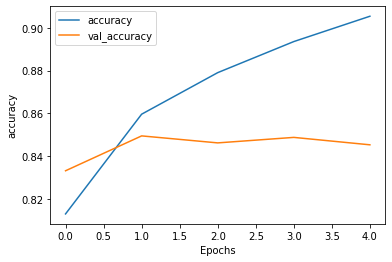

In [31]:
plot_graphs(history, 'accuracy')

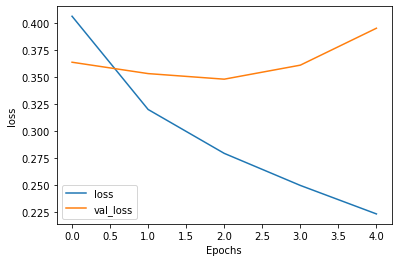

In [32]:
plot_graphs(history, 'loss')

In [33]:
# 테스트 데이터 준비
test_file = tf.keras.utils.get_file('ratings_test.txt', 
                                    origin='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt',
                                    extract=True)
test = pd.read_csv(test_file, sep='\t')
test.head()

4907008/4893335 [==============================] - 0s 0us/step


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [34]:
# 데이터 전처리
def preprocessing(df):
  df['document'] = df['document'].str.replace('[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ]', '')
  df = df.dropna()
  test_label = np.asarray(df['label'])
  test_data = df['document'].apply((lambda x: word_tokenization(x)))
  test_data = tokenizer.texts_to_sequences(test_data)
  test_data = pad_sequences(test_data, truncating=trunc_type, padding=padding_type, maxlen=max_length)
  return test_data, test_label
test_data, test_label = preprocessing(test)
print(model.evaluate(test_data, test_label))

1563/1563 [==============================] - 20s 13ms/step - loss: 0.4004 - accuracy: 0.8418
[0.4004330039024353, 0.8418193459510803]


In [35]:
# 저장된 모델 불러오기
model2 = create_model()
model2.evaluate(test_data, test_label)

1563/1563 [==============================] - 25s 14ms/step - loss: 0.6931 - accuracy: 0.5054


[0.693100094795227, 0.5053706765174866]

In [36]:
# 생성된 모델에 가중치 적용
model2.load_weights(checkpoint_path)
model2.evaluate(test_data, test_label)

1563/1563 [==============================] - 22s 14ms/step - loss: 0.3527 - accuracy: 0.8435


[0.35271909832954407, 0.8434960842132568]

In [37]:
# KoBERT
!git clone https://github.com/SKTBrain/KoBERT.git

Cloning into 'KoBERT'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 231 (delta 33), reused 30 (delta 12), pack-reused 155
Receiving objects: 100% (231/231), 199.27 KiB | 1.90 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [38]:
%cd KoBERT

/content/KoBERT


In [39]:
!pwd

/content/KoBERT


In [40]:
pip install -r requirements.txt

     |████████████████████████████████| 46.9 MB 44 kB/s 
     |████████████████████████████████| 344 kB 50.9 MB/s 
     |████████████████████████████████| 1.2 MB 39.2 MB/s 
     |████████████████████████████████| 4.5 MB 34.3 MB/s 
     |████████████████████████████████| 1.3 MB 38.4 MB/s 
     |████████████████████████████████| 2.9 MB 37.2 MB/s 
     |████████████████████████████████| 895 kB 40.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595742 sha256=9b9f7fe4a429565a9e5d0fa96bbc076d2b8d57f8e78bfefa12c33d03a38dc7b4
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [41]:
# KoBERT (gluonnlp) 토크나이저
from gluonnlp.data import SentencepieceTokenizer
from kobert.utils import get_tokenizer
tok_path = get_tokenizer()
sp = SentencepieceTokenizer(tok_path)
print(sp('영실아오늘날씨어때?'))
print(sp('영실아 오늘 날씨 어때?'))

[██████████████████████████████████████████████████]
['▁영', '실', '아', '오늘', '날', '씨', '어', '때', '?']
['▁영', '실', '아', '▁오늘', '▁날씨', '▁어', '때', '?']


In [42]:
def word_tokenization_kobert(text):
  stop_words = ['는', '을', '를', '이', '가', '의', '던', '고', '하', '다', 
                '은', '에', '들', '지', '게', '도']
  return [word for word in sp(text) if word not in stop_words]

In [45]:
def train_preprocessing(df):
  df['document'] = df['document'].str.replace('[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ]', '')
  df = df.dropna()
  data = df['document'].apply((lambda x: word_tokenization_kobert(x)))
  data = tokenizer.texts_to_sequences(data)
  data = pad_sequences(data, truncating=trunc_type, padding=padding_type, maxlen=max_length)

  training_size = 120000
  train_sentences = data[:training_size]
  valid_sentences = data[training_size:]
  train_labels = np.asarray(df['label'][:training_size])
  valid_labels = np.asarray(df['label'][training_size:])

  return train_sentences, valid_sentences, train_labels, valid_labels
train_padded, valid_padded, train_labels, valid_labels = train_preprocessing(train)

In [47]:
train_padded[:2]

array([[   1,   66,  886,   27,  918, 4649,    8,   22, 2372,  466,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1, 1018, 1941, 9676,  321,  833, 1236,    2,  108,  235, 1558,
        2897,   30,  773,    1,   32,  370,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,

In [49]:
model3 = create_model()
history3 = model3.fit(train_padded, train_labels,
                    validation_data=(valid_padded, valid_labels),
                    callbacks=[early_stop, checkpoint],
                    batch_size=32,
                    epochs=10, verbose=2)

Epoch 1/10
3750/3750 - 158s - loss: 0.4867 - accuracy: 0.7589 - val_loss: 0.4471 - val_accuracy: 0.7820

Epoch 00001: val_loss did not improve from 0.34813
Epoch 2/10
3750/3750 - 141s - loss: 0.4311 - accuracy: 0.7936 - val_loss: 0.4263 - val_accuracy: 0.7973

Epoch 00002: val_loss did not improve from 0.34813
Epoch 3/10
3750/3750 - 141s - loss: 0.4075 - accuracy: 0.8074 - val_loss: 0.4202 - val_accuracy: 0.7969

Epoch 00003: val_loss did not improve from 0.34813
Epoch 4/10
3750/3750 - 140s - loss: 0.3913 - accuracy: 0.8164 - val_loss: 0.4123 - val_accuracy: 0.8039

Epoch 00004: val_loss did not improve from 0.34813
Epoch 5/10
3750/3750 - 141s - loss: 0.3783 - accuracy: 0.8248 - val_loss: 0.4105 - val_accuracy: 0.8076

Epoch 00005: val_loss did not improve from 0.34813
Epoch 6/10
3750/3750 - 140s - loss: 0.3651 - accuracy: 0.8326 - val_loss: 0.4086 - val_accuracy: 0.8095

Epoch 00006: val_loss did not improve from 0.34813
Epoch 7/10
3750/3750 - 139s - loss: 0.3532 - accuracy: 0.8386 - 

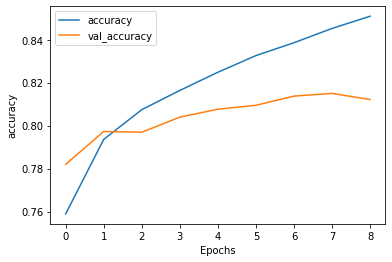

In [50]:
plot_graphs(history3, 'accuracy')

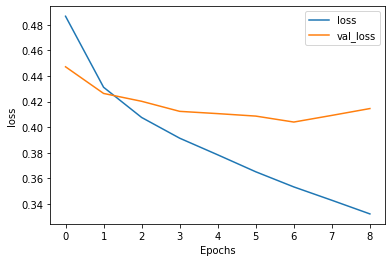

In [51]:
plot_graphs(history3, 'loss')